#  IMPLEMENTING MELON LEAF IMAGE CLASSIFICATION USING SUPPORT VECTOR MACHINE

Importing Libraries 

In [43]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

Reading the images directly from Kaggle

In [44]:
# Set the path to the images directory
image_dir = '/kaggle/input/melon-macronutrient-deficiency-dataset/Melon macronutrient deficeincy datasets/'

# Prepare image data and labels
images = []
labels = []
class_names = os.listdir(image_dir)

# Read images and labels
for class_name in class_names:
    class_path = os.path.join(image_dir, class_name)
    if os.path.isdir(class_path):
        for filename in os.listdir(class_path):
            file_path = os.path.join(class_path, filename)
            img = cv2.imread(file_path)
            if img is not None:
                img_resized = cv2.resize(img, (224, 224))  # Resize to match ResNet50 input size
                images.append(img_resized)
                labels.append(class_name)

#Convert the images into nampy array
images = np.array(images)
labels = np.array(labels)

# Print the shape of the images and labels
print(images.shape) #(should be n_samples, width, height, channels)
print(labels.shape) 

(200, 224, 224, 3)
(200,)


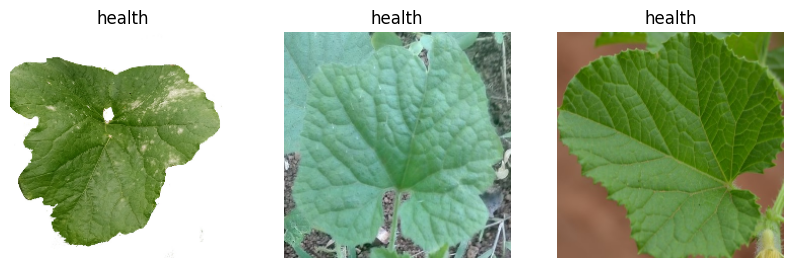

In [45]:
# Optionally, visualize a few images to confirm they're loaded correctly
plt.figure(figsize=(10, 10))
for i in range(3):  # Display 9 random images from the dataset
    plt.subplot(3, 3, i+1)
    plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for correct display
    plt.title(labels[i])
    plt.axis('off')
plt.show()

EXTRACTING FEATURES USING HOG AND CLASSIFICATION USING SVM

In [46]:
from skimage.feature import hog

# Function to extract HOG features
def extract_hog_features(images):
    hog_features = []
    for img in images:
        # Convert the image to grayscale
        gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # Extract HOG features
        fd, _ = hog(gray_image, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)
        hog_features.append(fd)
    return np.array(hog_features)

# Extract HOG features from the images
hog_features = extract_hog_features(images)

In [47]:
# Normalize the features
scaler = StandardScaler()
X_hog = scaler.fit_transform(hog_features)

In [48]:
# Split data for SVM
X_train_hog, X_test_hog, y_train_hog, y_test_hog = train_test_split(X_hog, labels, test_size=0.2, random_state=42)
print(X_train_hog.shape, X_test_hog.shape)

(160, 26244) (40, 26244)


In [49]:
# Train the SVM Classifier
svm_classifier = SVC(kernel='linear', random_state=42)
svm_classifier.fit(X_train_hog, y_train_hog)

SVC(kernel='linear', random_state=42)

In [50]:
# Making Predictions
y_pred_hog = svm_classifier.predict(X_test_hog)

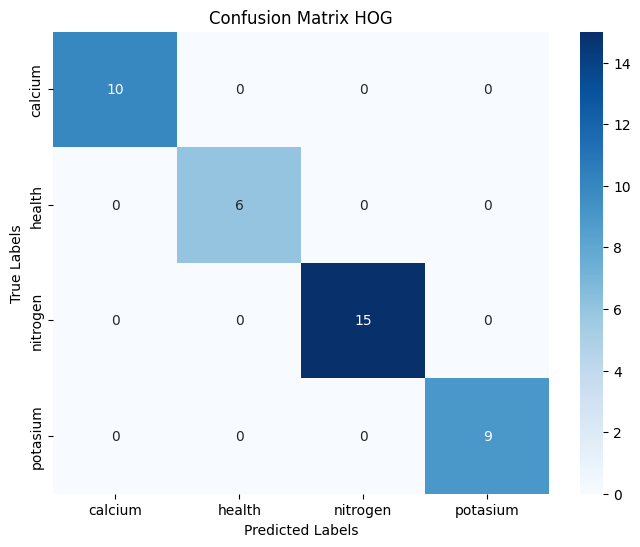

In [51]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test_hog, y_pred_hog)

# Visualize the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(labels), yticklabels=np.unique(labels))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix HOG')
plt.show()

In [53]:
# Classification Report (Precision, Recall, F1-Score)
class_report = classification_report(y_test_hog, y_pred_hog)

# Print Classification Report
print("Classification Report:\n", class_report)

Classification Report:
               precision    recall  f1-score   support

     calcium       1.00      1.00      1.00        10
      health       1.00      1.00      1.00         6
    nitrogen       1.00      1.00      1.00        15
    potasium       1.00      1.00      1.00         9

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40



EXTRACTING FEATURES USING MobileNetv2 AND CLASSIFICATION USING SVM

In [55]:
# Load the MobileNetV2 model with weights pre-trained on ImageNet
mobilenetv2_model = MobileNetV2(weights='imagenet', include_top=False, pooling='avg')

# Function to extract features using MobileNetV2
def extract_mobilenetv2_features(X_mobilenet):
    # Ensure input shape is (num_samples, 224, 224, 3)
    X_mobilenet = np.array(X_mobilenet)
    
    # If the shape is incorrect (e.g., has an extra dimension), reshape it
    if X_mobilenet.ndim == 5:
        X_mobilenet = np.squeeze(X_mobilenet, axis=1)  # Remove the extra dimension
    
    # Preprocess the images to match the format expected by MobileNetV2
    X_mobilenet = preprocess_input(X_mobilenet)
    
    # Extract features using MobileNetV2 (apply the model to the images)
    features = mobilenetv2_model.predict(X_mobilenet)
    
    return features

# Assuming 'images' is your dataset, call the function to extract features
mobilenetv2_features = extract_mobilenetv2_features(images)

# Print shape of the extracted features
print(f"MobileNetV2 features shape: {mobilenetv2_features.shape}")

<ipython-input-55-f12d37e32708>:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobilenetv2_model = MobileNetV2(weights='imagenet', include_top=False, pooling='avg')


7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 806ms/step
MobileNetV2 features shape: (200, 1280)


In [57]:
# Scaling the Features (StandardScaler)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(mobilenetv2_features)  # Scale the extracted features

In [58]:
# Split data for SVM
X_train, X_test, y_train, y_test = train_test_split(X_scaled, labels, test_size=0.2, random_state=42)

print(X_train.shape, X_test.shape)

(160, 1280) (40, 1280)


In [59]:
# Train the SVM Classifier
svm_classifier = SVC(kernel='linear', random_state=42)
svm_classifier.fit(X_train, y_train)

SVC(kernel='linear', random_state=42)

In [60]:
# Making Predictions
y_pred = svm_classifier.predict(X_test)

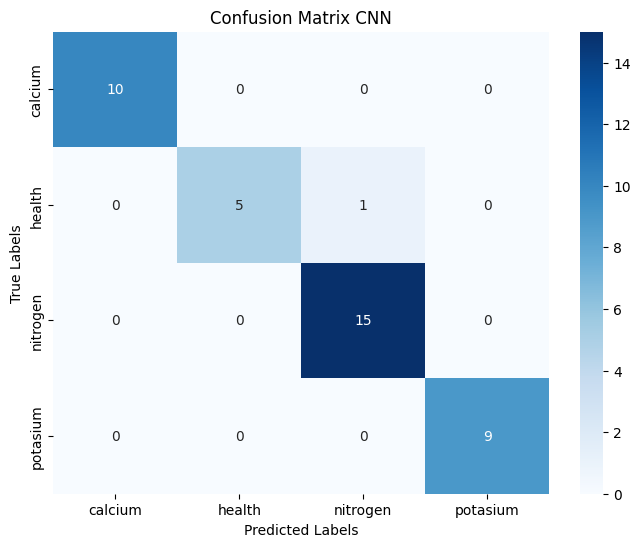

In [61]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualize the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(labels), yticklabels=np.unique(labels))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix CNN')
plt.show()

In [62]:
# Classification Report (Precision, Recall, F1-Score)
class_report = classification_report(y_test, y_pred)

# Print Classification Report
print("Classification Report:\n", class_report)

Classification Report:
               precision    recall  f1-score   support

     calcium       1.00      1.00      1.00        10
      health       1.00      0.83      0.91         6
    nitrogen       0.94      1.00      0.97        15
    potasium       1.00      1.00      1.00         9

    accuracy                           0.97        40
   macro avg       0.98      0.96      0.97        40
weighted avg       0.98      0.97      0.97        40

